# GDP


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.regression.quantile_regression as smq

## Read Data

In [3]:
economist: pd.DataFrame = pd.read_hdf("data/democracy.h5", "economist")
freedom_house: pd.DataFrame = pd.read_hdf("data/democracy.h5", "freedomhouse")
v_dem: pd.DataFrame = pd.read_hdf("data/democracy.h5", "vdem")

## Create Democracy Score

<AxesSubplot:xlabel='year'>

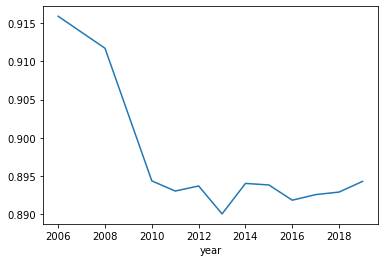

In [12]:
dem_raw = economist.add_prefix("econ-").join(freedom_house.add_prefix("free-"), how="outer").join(v_dem.add_prefix("v-dem-"), how="outer")
dem = dem_raw.copy().dropna()
dem["econ-score"] /= 10
dem["free-score"] = (7 - dem["free-score"])/6
dem["score"] = dem.mean(axis=1)
dem.to_hdf("data/democracy.h5", key="democracy")
dem_raw.to_hdf("data/democracy.h5", key="democracy_raw")
dem.loc["Netherlands"]["score"].plot()

## Get GDP data
Note: All data is in PPP (per capita) (as this is a much better measurement of wealth). Source: World Bank.

In [5]:
gdp = pd.read_csv("data/gdp.csv", skiprows=[0, 1, 2, 3], index_col=[0])
gdp.drop(["Country Code", "Indicator Name", "Indicator Code", "Unnamed: 65"], axis=1, inplace=True)
gdp.columns = gdp.columns.astype(int)
gdp = gdp.unstack().reorder_levels([1, 0]).sort_index().to_frame("gdp_per_capita")
gdp.index.set_names(["country_name", "year"], inplace=True)
gdp

gdp_per_capita
country_name year                
Afghanistan  1960             NaN
             1961             NaN
             1962             NaN
             1963             NaN
             1964             NaN
...                           ...
Zimbabwe     2016     2806.469032
             2017     3795.642431
             2018     4017.221716
             2019     3783.547898
             2020     3536.034132

[16226 rows x 1 columns]

## Get GDP Growth

In [6]:
gdp_growth = pd.read_csv("data/gdp_growth.csv", skiprows=[0, 1, 2, 3], index_col=[0])
gdp_growth.drop(["Country Code", "Indicator Name", "Indicator Code", "Unnamed: 65"], axis=1, inplace=True)
gdp_growth.columns = gdp_growth.columns.astype(int)
gdp_growth = gdp_growth.unstack().reorder_levels([1, 0]).sort_index().to_frame("gdp_growth")
gdp_growth.index.set_names(["country_name", "year"], inplace=True)
gdp_growth

gdp_growth
country_name year            
Afghanistan  1960         NaN
             1961         NaN
             1962         NaN
             1963         NaN
             1964         NaN
...                       ...
Zimbabwe     2016   -0.793105
             2017    3.192453
             2018    3.356166
             2019   -7.468627
             2020   -7.620388

[16226 rows x 1 columns]

## GDP to Democracy

Least Absolute Deviations because of the large outliers.

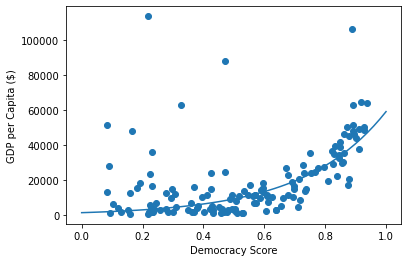

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:         gdp_per_capita   Pseudo R-squared:               0.2604
Model:                       QuantReg   Bandwidth:                      0.6252
Method:                 Least Squares   Sparsity:                        1.788
Date:                Wed, 26 Jan 2022   No. Observations:                  140
Time:                        11:46:20   Df Residuals:                      138
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2892      0.182     40.014      0.000       6.929       7.649
score          3.6978      0.307     12.037      0.000       3.090       4.305
==============================================================================
"""

In [7]:
gdp_pc_dem = gdp.join(dem).dropna()
# gdp_growth_v_dem.groupby(gdp_growth_v_dem.index.get_level_values(0)).mean()
rel_gdp_dem: pd.DataFrame =  gdp_pc_dem.loc[(slice(None), [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]), :]
rel_gdp_dem_avg = rel_gdp_dem.groupby(rel_gdp_dem.index.get_level_values(0)).mean()
# rel_gdp_dem_avg = rel_gdp_dem_avg[(rel_gdp_dem_avg["gdp_per_capita"] > 40000) & (rel_gdp_dem_avg["score"] < 0.5) == False]
plt.scatter(rel_gdp_dem_avg["score"], rel_gdp_dem_avg["gdp_per_capita"])
model = smq.QuantReg(np.log(rel_gdp_dem_avg["gdp_per_capita"]), sm.add_constant(rel_gdp_dem_avg[["score"]]))
res = model.fit(q=0.5)
x = np.linspace(0, 1)
plt.plot(x, np.exp(res.params[0] + res.params[1]*x))
plt.xlabel("Democracy Score")
plt.ylabel("GDP per Capita ($)")
plt.show()
res.summary()

## GDP Growth to Democracy
Note: Compensated to GDP

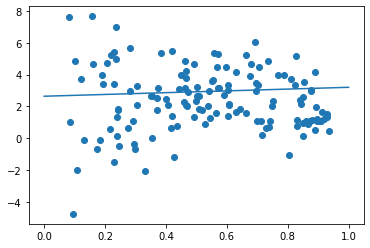

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gdp_growth   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     5.729
Date:                Wed, 26 Jan 2022   Prob (F-statistic):            0.00408
Time:                        11:46:20   Log-Likelihood:                -287.92
No. Observations:                 140   AIC:                             581.8
Df Residuals:                     137   BIC:                             590.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.6404      0.391      6.751      0.000       1.867       3.414
score              0.5603      0.727      0.770      0.442      -0.878       1.998
gdp_per_capita -2.949e-05   8.91e-06     -3.312      0.001   -4.71e-05   -1.19e-05
==============================================================================
Omnibus:                        2.574   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.276   Jarque-Bera (JB):                2.500
Skew:                          -0.040   Prob(JB):                        0.286
Kurtosis:                       3.650   Cond. No.                     1.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
gdp_growth_dem = gdp_growth.join(dem).join(gdp).dropna()
# gdp_growth_v_dem.groupby(gdp_growth_v_dem.index.get_level_values(0)).mean()
rel_gdp_growth_dem: pd.DataFrame =  gdp_growth_dem.loc[:, :]
rel_gdp_growth_dem_avg = rel_gdp_growth_dem.groupby(rel_gdp_growth_dem.index.get_level_values(0)).mean()
# rel_gdp_dem_avg = rel_gdp_dem_avg[(rel_gdp_dem_avg["gdp_per_capita"] > 40000) & (rel_gdp_dem_avg["score"] < 0.5) == False]
plt.scatter(rel_gdp_growth_dem_avg["score"], rel_gdp_growth_dem_avg["gdp_growth"])
model = sm.OLS(rel_gdp_growth_dem_avg["gdp_growth"], sm.add_constant(rel_gdp_growth_dem_avg[["score", "gdp_per_capita"]]))
res = model.fit(q=0.5)
x = np.linspace(0, 1)
plt.plot(x, res.params[0] + res.params[1]*x)
plt.show()
res.summary()

## Median GDP per Democracy Score

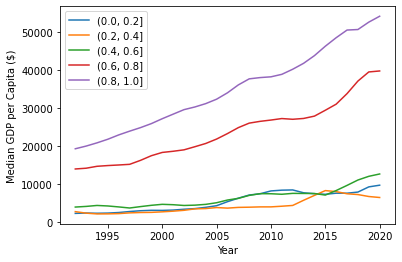

In [9]:
dem_gdp = dem_raw.join(gdp)
bins = pd.cut(dem_gdp["v-dem-score"], bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
dem_gdp_data = dem_gdp.groupby([bins, "year"]).median()["gdp_per_capita"].reorder_levels([1, 0]).sort_index().unstack().rolling(3).mean()
dem_gdp_data.dropna(how="all", inplace=True)
plt.plot(dem_gdp_data)
plt.legend(dem_gdp_data.columns)
plt.xlabel("Year")
plt.ylabel("Median GDP per Capita ($)")
plt.show()